In [1]:
import pandas as pd
import numpy as np
from math import cos, sin

from scipy.integrate import odeint
from scipy.integrate import solve_ivp

from matplotlib import pyplot as plt

In [2]:
'''
In 2D
The initial state has the form 
state[:,0] = mass
state[0,1:3], state[0,3:6] = p1 (px1, py1), v1 // position not momenta
state[1,1:3], state[1,3:6] = p2 (px2, py2), v2
state[2,1:3], state[2,3:6] = p3 (px3, py3), v3
'''


'''
def get_accelerations(state, epsilon=0):
    net_accs = [] # [nbodies x 2]
    for i in range(state.shape[0]): # number of bodies
        other_bodies = np.concatenate([state[:i, :], state[i+1:, :]], axis=0)
        displacements = other_bodies[:, 1:3] - state[i, 1:3] # indexes 1:3 -> pxs, pys
        distances = (displacements**2).sum(1, keepdims=True)**0.5 # shape=(2,1) consist of euclidian distances from particles j to particle i
        masses = other_bodies[:, 0:1] # index 0 -> mass
        pointwise_accs = masses * displacements / (distances**3 + epsilon) # G=1
        net_acc = pointwise_accs.sum(0, keepdims=True)
        net_accs.append(net_acc)
    net_accs = np.concatenate(net_accs, axis=0)
    return net_accs    


def update(t, state):
    state = state.reshape(-1,5)
    deriv = np.zeros_like(state)
    deriv[:,1:3] = state[:,3:5] # dx, dy = vx, vy for all bodies
    deriv[:,3:5] = get_accelerations(state)
    return derivs.reshape(-1)

nbodies = state.shape[0]
t_eval = np.linspace(t_span[0], t_span[1], t_points)
path = solve_ivp(fun=update, t_span=t_span, y0=state.flatten(), t_eval=t_eval, **kwargs)


'''

'\ndef get_accelerations(state, epsilon=0):\n    net_accs = [] # [nbodies x 2]\n    for i in range(state.shape[0]): # number of bodies\n        other_bodies = np.concatenate([state[:i, :], state[i+1:, :]], axis=0)\n        displacements = other_bodies[:, 1:3] - state[i, 1:3] # indexes 1:3 -> pxs, pys\n        distances = (displacements**2).sum(1, keepdims=True)**0.5 # shape=(2,1) consist of euclidian distances from particles j to particle i\n        masses = other_bodies[:, 0:1] # index 0 -> mass\n        pointwise_accs = masses * displacements / (distances**3 + epsilon) # G=1\n        net_acc = pointwise_accs.sum(0, keepdims=True)\n        net_accs.append(net_acc)\n    net_accs = np.concatenate(net_accs, axis=0)\n    return net_accs    \n\n\ndef update(t, state):\n    state = state.reshape(-1,5)\n    deriv = np.zeros_like(state)\n    deriv[:,1:3] = state[:,3:5] # dx, dy = vx, vy for all bodies\n    deriv[:,3:5] = get_accelerations(state)\n    return derivs.reshape(-1)\n\nnbodies = sta

# Second-order ODE:

y'' +2y' +2y = cos(2x)

## Turn into two first-order ODEs:

* z = y' -> dy/dx = z
* z' + 2z +2y = cos(2x) -> dz/dx = -2z - 2y + cos(2x)

In [3]:
def dUdx(U,x):
    # U is a vector such that U[0] = y, U[1] = z
    # dUdx returns [y',z'] = [dydx, dzdx]
    return [U[1], -2 * U[1] - 2 * U[0] + np.cos(2*x)]

def dUdx_inv2(x, U):
    return [U[1], -2.0 * U[1] - 2 * U[0] + np.cos(2*x)]

In [4]:
def dUdx_inv(x, U):
    return -2 * U[0] - 2 * U[1] + np.cos(2*x)

In [5]:
def rk4(func, U, t, h):
    
    U_next = np.zeros_like(U)
    
    for i in range(U.shape[0]):
        body = U[i]       
    
        k1 = func(t, body)
        k2 = func(t + h * 0.5, body + k1 * 0.5 * h)
        k3 = func(t + h * 0.5, body + k2 * 0.5 * h)
        k4 = func(t + h, body + k3 * h)

        v = body[1] + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6

        # v doesn't explicitly depend on other variables
        k1 = k2 = k3 = k4 = v

        u = body[0] + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        
        U_next[i] = np.array([u, v])

    return U_next

In [6]:
U0 = np.array([1,1]) # [y0, z0]
# time intervall
t_eval = [0,10]
timepoints = 500
xs = np.linspace(t_eval[0], t_eval[1], timepoints)
h = (t_eval[1] - t_eval[0]) / (timepoints - 1)

# get solution from odeint
Us_odeint = odeint(dUdx, U0, xs)
sol_odeint = Us_odeint[:,0]

# get solution from solve_ivp
Us_solve_ivp = solve_ivp(dUdx_inv2, y0=U0, t_span=[xs[0], xs[-1]], t_eval=xs)
sol_ivp = Us_solve_ivp.y[0]

bodies = 1
ODEs = 2
sol_rk4 = np.zeros(shape=(timepoints+1, bodies, ODEs))

# set initial condition
sol_rk4[0,0,:] = U0

for t in range(len(xs)):    
    sol_rk4[t+1] = rk4(dUdx_inv, sol_rk4[t], xs[t], h)

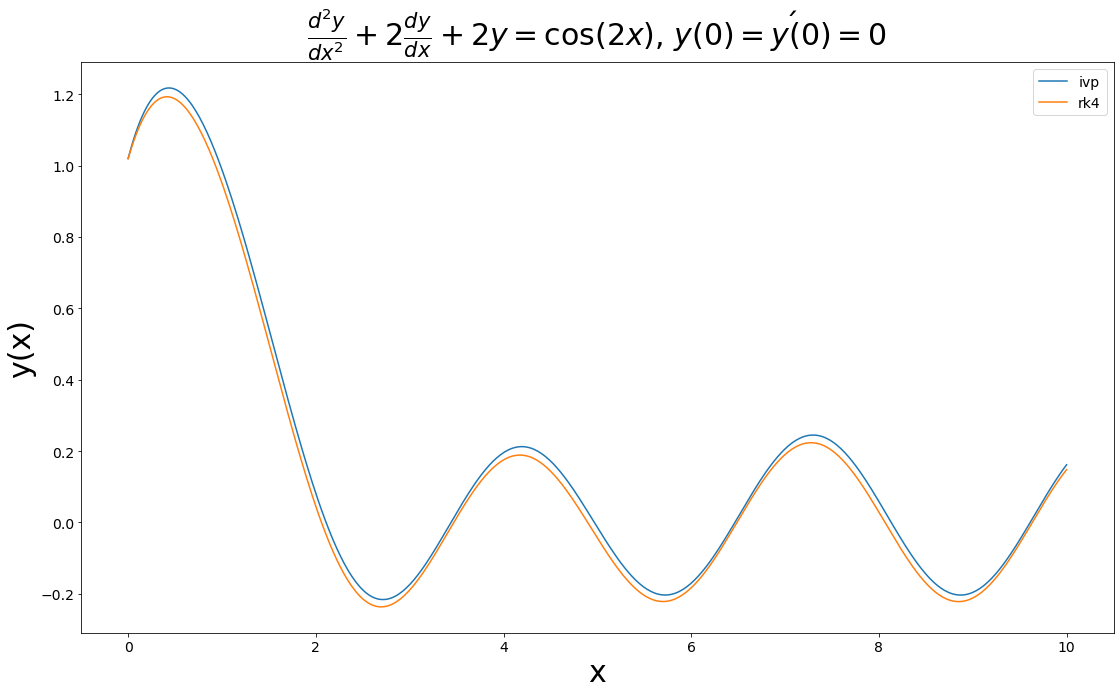

In [13]:
# Plot the numerical solution
# plot results
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.rcParams.update({'font.size': 14})  # increase the font size

#plt.plot(xs, sol_odeint, label='odeint')
plt.plot(xs, [x + 0.02 for x in sol_ivp], label='ivp')
plt.plot(xs, sol_rk4[:,:,0][1:], label='rk4')

plt.title(r'$\frac{d^2y}{dx^2} + 2\frac{dy}{dx} + 2y = \cos(2x)$, $y(0)=y\'(0)=0$', fontsize=30)
plt.xlabel('x', fontsize=30)
plt.ylabel('y(x)', fontsize=30)
plt.legend(loc='best', fontsize=20)


plt.legend(loc='best')